In [1]:
import numpy as np
import gym
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

### Create an instance of Blackjack environment

In [2]:
env = gym.make('Blackjack-v0')
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

State space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

### Playing blackjack with random policy

In [3]:
for i in range(5):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print("Game Over. Reward: {}".format(reward))
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

Game Over. Reward: 1.0
You won :)

Game Over. Reward: 1.0
You won :)

Game Over. Reward: -1
You lost :(

Game Over. Reward: -1.0
You lost :(

Game Over. Reward: -1
You lost :(



### MC Prediction

In [12]:
def generate_stochastic_episode(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.85, 0.15] if state[0] > 18 else [0.15, 0.85]
        action = np.random.choice([0, 1], p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [13]:
for i in range(5):
    print(generate_stochastic_episode(env))

[((5, 10, False), 0, -1.0)]
[((16, 1, False), 1, -1)]
[((14, 10, False), 1, -1)]
[((15, 8, False), 1, -1)]
[((9, 3, False), 0, -1.0)]


In [14]:
def mc_prediction(env, num_epiodes, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(num_epiodes):
        if (i_episode+1) % 1000 == 0:
            print("\rEpisode {}/{}".format(i_episode+1, num_epiodes), end="")
            
        episode = generate_stochastic_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(states)+1)])

        for i in range(len(states)):
            N[states[i]][actions[i]] += 1
            returns_sum[states[i]][actions[i]] += sum(rewards[i:] * discounts[:-(i+1)])
    
    for state in N.keys():
        Q[state] = returns_sum[state]/ N[state]
    return Q

Episode 5000/5000

C:\Users\windo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


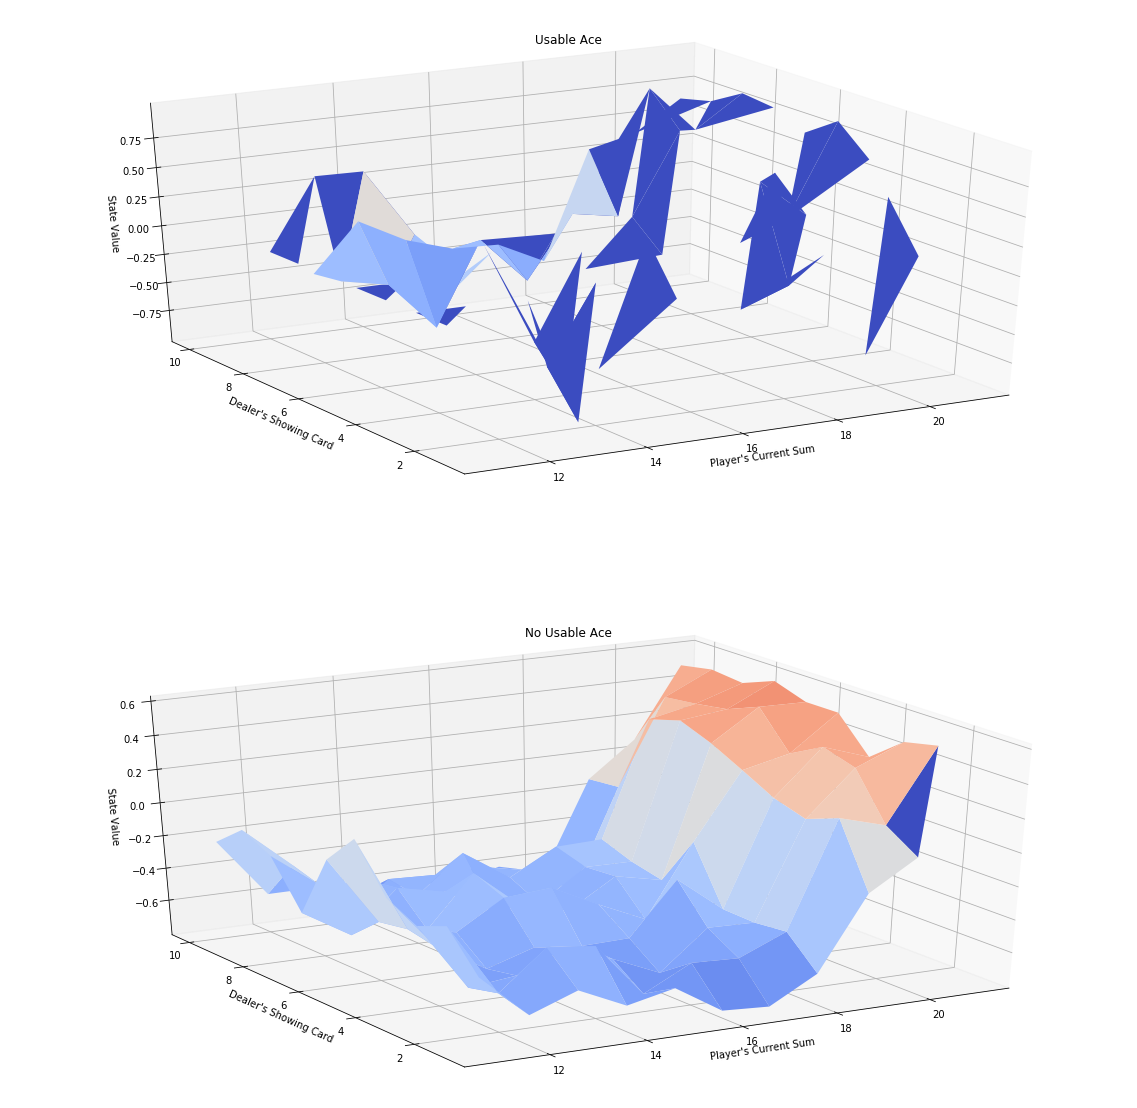

In [16]:
Q = mc_prediction(env, num_epiodes=500000, gamma=0.99)

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### MC Control

In [17]:
def generate_policy(Q):
    policy = defaultdict(lambda: 0)
    for state in Q.keys():
        policy[state] = np.argmax(Q[state])
    return policy
    
def generate_episode(env, Q, epsilon):
    policy = generate_policy(Q)
    episode = []
    state = env.reset()
    
    while True:
        if state in policy.keys():
            explore = np.random.choice([0,1], p=[1-epsilon, epsilon])
            if not explore:
                action = policy[state]
            else:
                action = env.action_space.sample()
        else:
            action = env.action_space.sample()
        
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [47]:
def mc_control(env, num_episodes, alpha, epsilon=1.0, gamma=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(num_episodes):
        
        epsilon = max(epsilon*0.9995, 0.01)
        
        if (i_episode+1) % 1000 == 0:
            print("\rEpisode {}/{}".format(i_episode+1, num_episodes), end="")
        
        episode = generate_episode(env, Q, epsilon)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(states)+1)])
        
        for i in range(len(states)):
            curr_estimate = Q[states[i]][actions[i]]
            target_estimate = alpha*(sum(rewards[i:]*discounts[:-(i+1)])-curr_estimate)
            Q[states[i]][actions[i]] += target_estimate
#             Q[states[t]][actions[t]] = Q[states[t]][actions[t]] + (alpha*((sum(rewards[t:]*discounts[:-(t+1)]))-Q[states[t]][actions[t]]))
    return Q

Episode 500000/500000

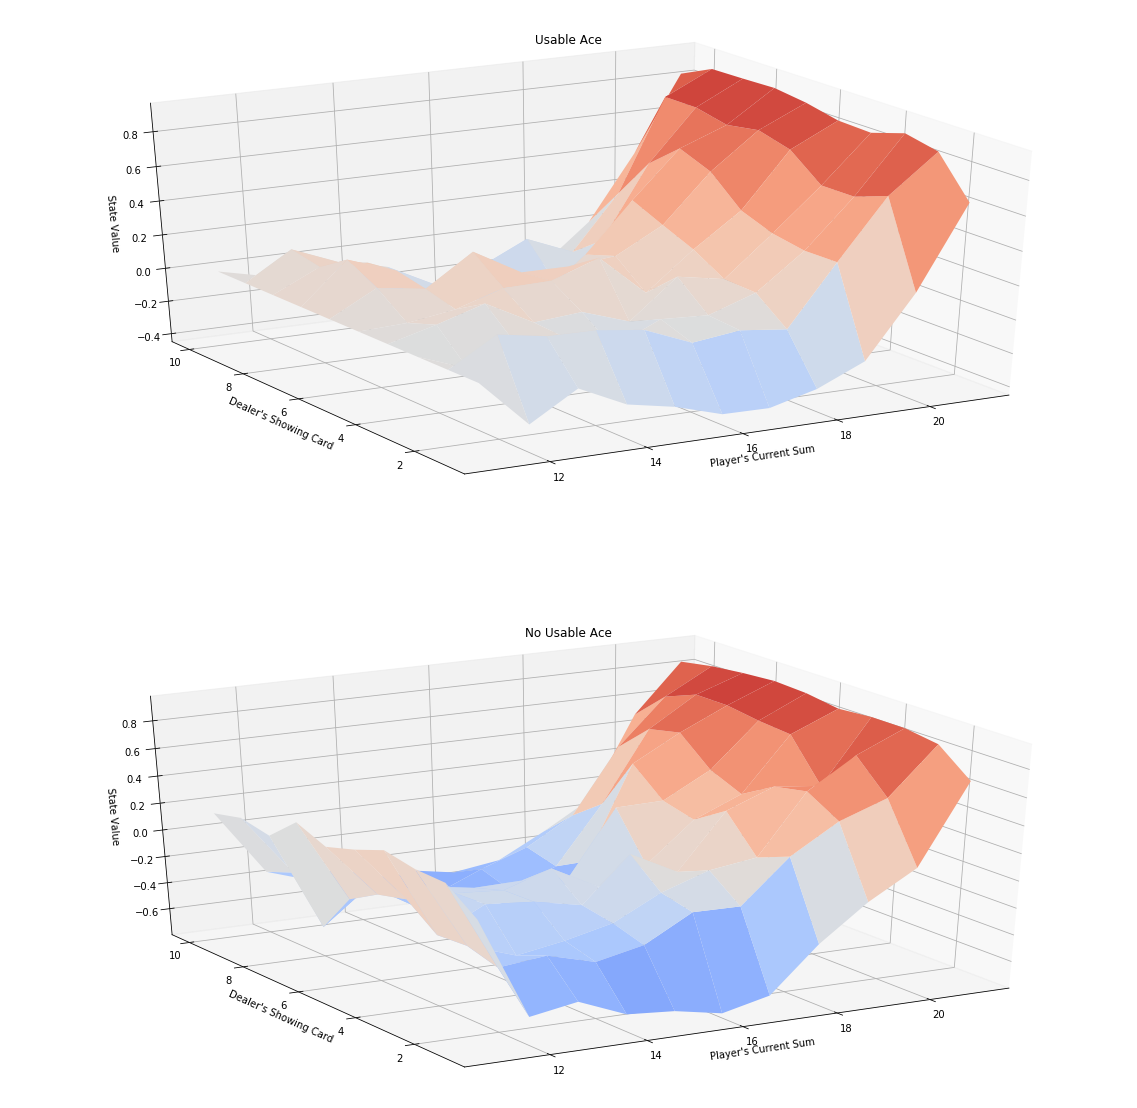

In [48]:
Q = mc_control(env, num_episodes=500000, alpha=0.02, epsilon=1.0, gamma=0.98)
policy = generate_policy(Q)

V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

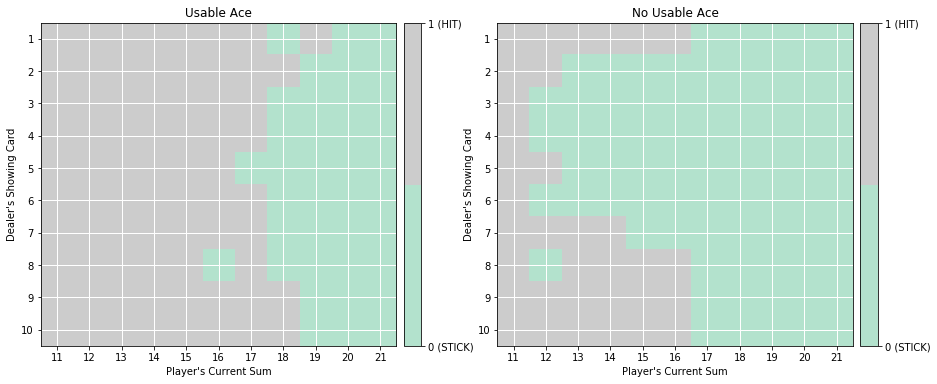

In [49]:
plot_policy(policy)

### Playing blackjack with the learned policy

In [51]:
for i in range(5):
    state = env.reset()
    while True:
        action = policy[state]
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print("Game Over. Reward: {}".format(reward))
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

Game Over. Reward: 1.0
You won :)

Game Over. Reward: 1.0
You won :)

Game Over. Reward: 1.0
You won :)

Game Over. Reward: 0.0
You lost :(

Game Over. Reward: 1.0
You won :)

